In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Rozmiar zbioru treningowego:", x_train.shape)  # Zobacz, ile przykładów i rozmiar każdego przykładu
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# Możesz również wyświetlić przykład obrazu z CIFAR-10
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Conv2D,Input,BatchNormalization, AveragePooling2D,Flatten,Activation, Dropout
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')



Rozmiar zbioru treningowego: (50000, 32, 32, 3)


In [2]:
image_size = x_train.shape[1]

In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [4]:
# Twrorzenie autokodera

l_warstw = 2
batch_size = 128
kernel_size = 3
latent_dim = 100
# Liczba warstw CNN pełniących funkcję koderów/dekoderów oraz liczba filtrów na warstwę
layer_filters = [16,32,64]
inputs = Input(shape=(32,32,3), name='koder_wejscie')
x = inputs
# stos Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='elu',
    strides=2,
    padding='same')(x)
shape = K.int_shape(x)
# generowanie wektora niejawnego
x = Flatten()(x)
latent = Dense(latent_dim, name='wektor_niejawny')(x)
# tworzenie instancji modelu kodera
encoder = Model(inputs,
    latent,
    name='koder')
encoder.summary()

# budowanie modelu dekodera
latent_inputs = Input(shape=(latent_dim,), name='koder_wejscie')
# użycie zapisanej wcześniej postaci (7,7,64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# z wektora do formy odpowiedniej dla transponowanej conv
x = Reshape((shape[1], shape[2], shape[3]))(x)
# stos Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)
# rekonstrukcja sygnałów wejściowych
outputs = Conv2DTranspose(filters=3,
kernel_size=kernel_size,
activation='relu',
padding='same',
name='dekoder_wyjscie')(x)
# tworzenie instancji modelu dekodera
decoder = Model(latent_inputs, outputs, name='dekoder')

Model: "koder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejscie (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 wektor_niejawny (Dense)     (None, 100)               102500    
                                                                 
Total params: 126,084
Trainable params: 126,084
Non-trainable

In [5]:
autoencoder = Model(inputs,
decoder(encoder(inputs)),
name='autokoder')
autoencoder.summary()

# funkcja straty jako błąd średniokwadratowy (MSE), optymalizator Adam
autoencoder.compile(loss='mse', optimizer='adam')
# trenowanie sieci autokodującej
autoencoder.fit(x_train,
x_train,
validation_data=(x_test, x_test),
    epochs=10,
    batch_size=batch_size)

x_decoded = autoencoder.predict(x_test)
# wyświetlenie pierwszych ośmiu wejściowych obrazów i zrekonstruowanych obrazów


Model: "autokoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejscie (InputLayer)  [(None, 32, 32, 3)]       0         
                                                                 
 koder (Functional)          (None, 100)               126084    
                                                                 
 dekoder (Functional)        (None, 32, 32, 3)         163875    
                                                                 
Total params: 289,959
Trainable params: 289,959
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 56s 90ms/step - loss: 0.0303 - val_loss: 0.0157
Epoch 2/10
391/391 [==============================] - 21s 53ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 3/10
391/391 [==============================] - 21s 54ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 4/1

In [6]:
x_decoded = autoencoder.predict(x_test)

313/313 [==============================] - 10s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


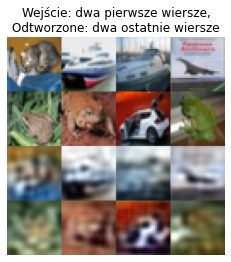

In [7]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, 32, 32,3))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Wejście: dwa pierwsze wiersze,\nOdtworzone: dwa ostatnie wiersze')
plt.imshow(imgs)
plt.savefig('wejściowe_i_odtworzone.png')
plt.show()